In [1]:
import requests
import torch
from PIL import Image
from transformers import AutoModelForCausalLM, AutoProcessor

model_id = 'microsoft/Florence-2-base'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

def run_example(image, task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

/Users/somogyijanos/Repos/somogyijanos/smartrobe/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from matplotlib import pyplot as plt
from PIL import ImageDraw
import numpy as np
import random

def draw_ocr_bboxes(image, prediction, scale=1):
    colormap = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta']
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",
        
                    fill=color)
       
    display(image)

In [25]:
def select_greatest_bbox(bboxes, labels):
    bbox_data = []
    
    for idx, bbox in enumerate(bboxes):
        # bbox is a polygon with 8 coordinates [x1, y1, x2, y2, x3, y3, x4, y4]
        # Convert to min/max coordinates to calculate height
        y_coords = [bbox[i] for i in range(1, len(bbox), 2)]
        
        min_y, max_y = min(y_coords), max(y_coords)
        
        height = max_y - min_y
        
        bbox_data.append({
            'label': labels[idx],
            'height': height
        })
    
    # Sort by height in descending order
    bbox_data_sorted = sorted(bbox_data, key=lambda x: x['height'], reverse=True)
    
    # Return simple list of labels ordered by height
    return [item['label'] for item in bbox_data_sorted]


In [46]:
def select_overlapping_labels(all_labels: list[list[str]]):
    """
    Find the most prioritized and similar labels across multiple lists.
    
    Args:
        all_labels: List of label lists, where each inner list is ordered by priority
    
    Returns:
        List of matching labels ordered by their combined priority and similarity score
    """
    from difflib import SequenceMatcher
    import re
    
    if len(all_labels) < 2:
        return []
    
    def clean_label(label):
        """Clean OCR artifacts and normalize text"""
        # Remove OCR tokens like </s> and other angle bracket tokens
        clean = re.sub(r'<[^>]*/?>', '', label)
        # Remove extra whitespace and strip
        clean = re.sub(r'\s+', ' ', clean.strip())
        return clean
    
    def calculate_similarity(text1, text2):
        """Calculate similarity between two text strings"""
        text1_lower = text1.lower()
        text2_lower = text2.lower()
        
        # Basic sequence similarity
        seq_similarity = SequenceMatcher(None, text1_lower, text2_lower).ratio()
        
        # Substring bonus: if one is contained in the other
        if text1_lower in text2_lower or text2_lower in text1_lower:
            shorter_len = min(len(text1_lower), len(text2_lower))
            longer_len = max(len(text1_lower), len(text2_lower))
            substring_bonus = shorter_len / longer_len * 0.3
            seq_similarity = min(1.0, seq_similarity + substring_bonus)
        
        return seq_similarity
    
    def calculate_priority_score(positions, total_lists):
        """Calculate priority score based on positions in each list"""
        # Lower positions (earlier in list) get higher scores
        # Missing from a list gets penalty
        if len(positions) < total_lists:
            coverage_penalty = len(positions) / total_lists
        else:
            coverage_penalty = 1.0
        
        # Average inverse position (1/position) for priority
        avg_priority = sum(1.0 / (pos + 1) for pos in positions) / len(positions)
        
        return avg_priority * coverage_penalty
    
    # Create candidate matches by comparing labels across all lists
    candidates = {}
    similarity_threshold = 0.6
    
    for i, list1 in enumerate(all_labels):
        for pos1, label1 in enumerate(list1):
            clean1 = clean_label(label1)
            if not clean1:
                continue
                
            # Compare with labels from other lists
            for j, list2 in enumerate(all_labels):
                if i >= j:  # Only compare each pair once
                    continue
                    
                for pos2, label2 in enumerate(list2):
                    clean2 = clean_label(label2)
                    if not clean2:
                        continue
                    
                    similarity = calculate_similarity(clean1, clean2)
                    
                    if similarity >= similarity_threshold:
                        # Use the shorter/cleaner label as the canonical form
                        if len(clean1) <= len(clean2):
                            canonical_label = clean1
                            original_label = label1
                        else:
                            canonical_label = clean2
                            original_label = label2
                        
                        canonical_key = canonical_label.lower()
                        
                        if canonical_key not in candidates:
                            candidates[canonical_key] = {
                                'label': canonical_label,
                                'original': original_label,
                                'positions': {},
                                'similarities': [],
                                'list_count': 0
                            }
                        
                        # Track positions in each list
                        candidates[canonical_key]['positions'][i] = pos1
                        candidates[canonical_key]['positions'][j] = pos2
                        candidates[canonical_key]['similarities'].append(similarity)
                        
                        # Update list count
                        candidates[canonical_key]['list_count'] = len(candidates[canonical_key]['positions'])
    
    # Score and rank candidates
    scored_candidates = []
    
    for key, candidate in candidates.items():
        positions = list(candidate['positions'].values())
        avg_similarity = sum(candidate['similarities']) / len(candidate['similarities'])
        priority_score = calculate_priority_score(positions, len(all_labels))
        
        # Combined score: priority * similarity * coverage
        coverage_boost = candidate['list_count'] / len(all_labels)
        final_score = priority_score * avg_similarity * (1 + coverage_boost)
        
        scored_candidates.append({
            'label': candidate['label'],
            'original': candidate['original'],
            'score': final_score,
            'list_count': candidate['list_count'],
            'avg_similarity': avg_similarity,
            'positions': positions
        })
    
    # Sort by score (highest first) and return labels
    scored_candidates.sort(key=lambda x: x['score'], reverse=True)
    
    return [candidate['label'] for candidate in scored_candidates]

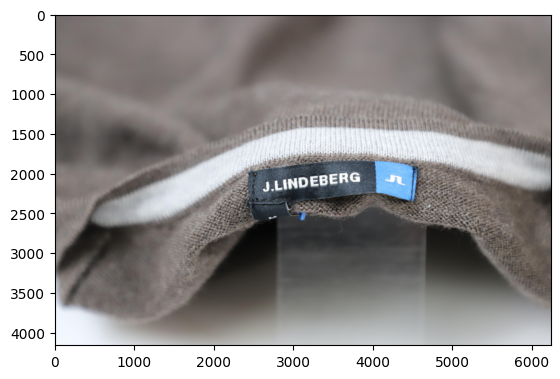

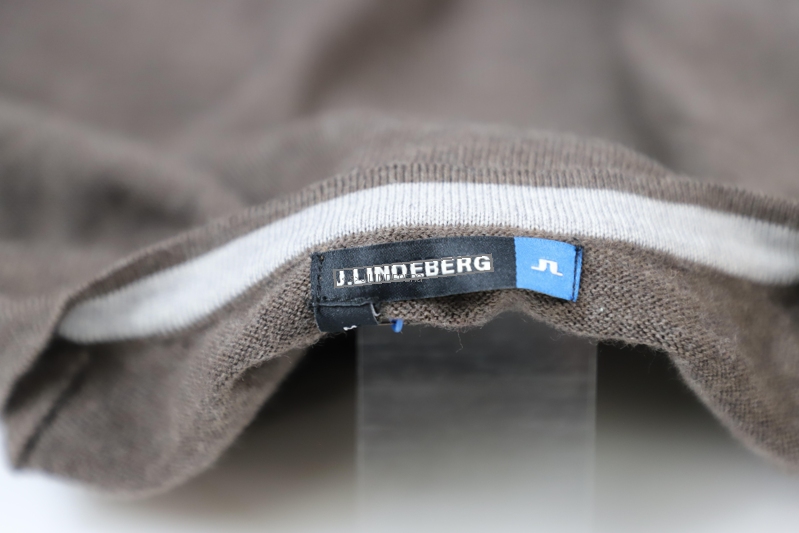

</s>J.LINDEBERG


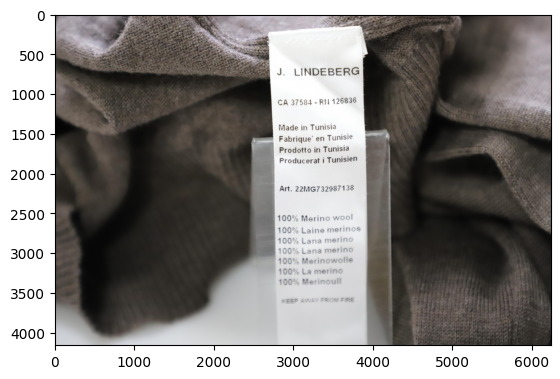

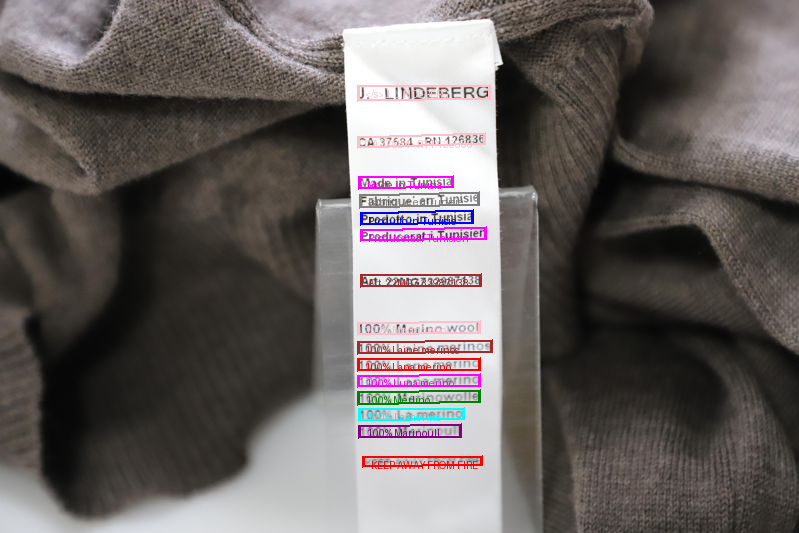

Fabrique en Tunisie
</s>J. LINDEBERG
CA 37584 - R11 126836
Produtto in Tunisie
100% Merlino
Producerat i Tunisien
100% Merino wool
100% Lana merino
100% Marinoull
Made in Tunisia
100% Luna merino
100% La merino
Art. 22MG7 32987138
100% Laine merinos
KEEP AWAY FROM FIRE
['J.LINDEBERG']


In [50]:
from matplotlib import pyplot as plt
import copy

# image_paths = [
#     # "/Users/somogyijanos/Repos/somogyijanos/smartrobe/test-images/01/2025_08_2009_40_370037.JPG",
#     # "/Users/somogyijanos/Repos/somogyijanos/smartrobe/test-images/01/2025_08_2009_40_490038.JPG",
#     "/Users/somogyijanos/Repos/somogyijanos/smartrobe/test-images/01/2025_08_2009_41_010079.JPG",
#     "/Users/somogyijanos/Repos/somogyijanos/smartrobe/test-images/01/2025_08_2009_41_120080.JPG"
# ]

# image_paths = [
#     "/Users/somogyijanos/Repos/somogyijanos/smartrobe/test-images/04/IMG_0168.JPG",
#     "/Users/somogyijanos/Repos/somogyijanos/smartrobe/test-images/04/IMG_0169_1.JPG"
# ]

# image_paths = [
#     "/Users/somogyijanos/Repos/somogyijanos/smartrobe/test-images/15/IMG_26194.JPG",
#     "/Users/somogyijanos/Repos/somogyijanos/smartrobe/test-images/15/IMG_26195.JPG"
# ]
image_paths = [
    "/Users/somogyijanos/Repos/somogyijanos/smartrobe/test-images/22/IMG_26304.JPG",
    "/Users/somogyijanos/Repos/somogyijanos/smartrobe/test-images/22/IMG_26305.JPG"
]

ocr_labels = []

for image_path in image_paths:

    image = Image.open(image_path)
    plt.imshow(image)
    plt.show()
    task_prompt = '<OCR_WITH_REGION>'
    results = run_example(image, task_prompt)
    # print(results)


    output_image = copy.deepcopy(image)
    w, h = output_image.size
    scale = 800 / max(w, h)
    new_output_image = output_image.resize((int(w * scale), int(h * scale)))
    draw_ocr_bboxes(new_output_image, results['<OCR_WITH_REGION>'], scale=scale)
    labels_ordered = select_greatest_bbox(results['<OCR_WITH_REGION>']['quad_boxes'], results['<OCR_WITH_REGION>']['labels'])
    ocr_labels.append(labels_ordered)
    for label in labels_ordered:
        print(label)

print(select_overlapping_labels(ocr_labels))
